# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, when, isnull
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .config("config option","config value")\
    .getOrCreate()

spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1578672246867'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.host', '1bedf3c14e4d'),
 ('config option', 'config value'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.port', '39585')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# Load input data
data_sparkify = "mini_sparkify_event_data.json"
df_sprk = spark.read.json(data_sparkify)
df_sprk.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
# Covert data into paandas dataframe
df = df_sprk.toPandas()
df.head() # data loaded successfully

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [5]:
print(df.shape) # 286,500 rows and 15 columns
print(df.dtypes)

(286500, 18)
artist            object
auth              object
firstName         object
gender            object
itemInSession      int64
lastName          object
length           float64
level             object
location          object
method            object
page              object
registration     float64
sessionId          int64
song              object
status             int64
ts                 int64
userAgent         object
userId            object
dtype: object


In [6]:
df.describe() # summary of the numercial data

,itemInSession,length,registration,sessionId,status,ts
count,286500.000000,228108.000000,2.781540e+05,286500.000000,286500.000000,2.865000e+05
mean,114.414213,249.117182,1.535359e+12,1041.526555,210.054597,1.540957e+12
std,129.767262,99.235179,3.291322e+09,726.776263,31.505078,1.507544e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,336.000000,200.000000,1.539697e+12
50%,70.000000,234.500770,1.536664e+12,1013.000000,200.000000,1.540932e+12
75%,156.250000,277.158730,1.537672e+12,1675.000000,200.000000,1.542266e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


In [7]:
df.isnull().sum() # Count of null values for each columns
#userId has zero null values

artist           58392
auth                 0
firstName         8346
gender            8346
itemInSession        0
lastName          8346
length           58392
level                0
location          8346
method               0
page                 0
registration      8346
sessionId            0
song             58392
status               0
ts                   0
userAgent         8346
userId               0
dtype: int64

In [8]:
df['userId'].value_counts() # Count of records by userid

39        9632
          8346
92        7230
140       6880
300011    5732
124       4825
300021    4659
300017    4428
85        4370
42        4257
200023    3769
6         3761
29        3603
54        3437
100       3214
9         3191
126       3102
300015    3051
91        3014
98        2891
74        2887
118       2868
136       2567
65        2544
138       2469
88        2465
51        2464
4         2442
97        2404
81        2335
          ... 
300007     143
144        125
154        118
72         117
57         112
32         108
63         107
300024     102
84          97
100019      89
200012      84
116         79
100003      78
200007      76
100017      75
34          73
64          68
122         62
134         52
68          48
90          45
133         44
100006      44
22          40
100024      36
300003      35
100011      23
125         11
156          6
135          6
Name: userId, Length: 226, dtype: int64

For the 8346 records we have observed that userId is blank but not categoriesed as null. Since we will be analysing and predicting the data based on the userIds, these records should be removed from the dataset

In [9]:
#Remove blank user ids
df_sprk = df_sprk[df_sprk["userId"] != ""]

In [10]:
df_sprk.count() #blank user ids removed succesfully

278154

In [11]:
df = df[df["userId"] != ""]

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [12]:
df_sprk.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [13]:
# creating time column in datetime format using from ts column 
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df_sprk = df_sprk.withColumn("time", get_time(df_sprk.ts))

In [14]:
df_sprk.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string'),
 ('time', 'string')]

In [15]:
df_sprk.select(['userId', 'page', 'time', 'level','ts']).sort("time").show(5)

+------+--------+-------------------+-----+-------------+
|userId|    page|               time|level|           ts|
+------+--------+-------------------+-----+-------------+
|    30|NextSong|2018-10-01 00:01:57| paid|1538352117000|
|     9|NextSong|2018-10-01 00:03:00| free|1538352180000|
|    30|NextSong|2018-10-01 00:06:34| paid|1538352394000|
|     9|NextSong|2018-10-01 00:06:56| free|1538352416000|
|    30|NextSong|2018-10-01 00:11:16| paid|1538352676000|
+------+--------+-------------------+-----+-------------+
only showing top 5 rows



#### Chrun identification 

Identify`Churn` users using the `Cancellation Confirmation` events to identify churn, which happen for both paid and free users. 


In [16]:
# created customer churn flag
churn_flag = udf(lambda x:1 if x=="Cancellation Confirmation" else 0, IntegerType())
df_sprk = df_sprk.withColumn("churn_flag",churn_flag("page"))

# User that have Churned once
val1 = Window.partitionBy('userId')
df_sprk = df_sprk.withColumn('churn', max('churn_flag').over(val1))

#### Downgrade identification 

Identify `downgrade` users using the `Submit downgrade` events to identify downgrade 


In [17]:
# created customer downgrade flag
down_flag = udf(lambda x:1 if x=="Submit Downgrade" else 0, IntegerType())
df_sprk = df_sprk.withColumn("Downgrade_flag", down_flag("page"))


# label Downgraded users (if Downgraded  once)
val2 = Window.partitionBy('userId')
df_sprk = df_sprk.withColumn('Downgraded', max('Downgrade_flag').over(val2))

In [18]:
#Drop the flag columns as 
columns_to_drop = ['churn_flag', 'Downgrade_flag']
df_sprk = df_sprk.drop(*columns_to_drop)

In [19]:
df_sprk.select(["userId", "Churn","Downgraded"]).sort("time").show(5)

+------+-----+----------+
|userId|Churn|Downgraded|
+------+-----+----------+
|    30|    0|         1|
|     9|    0|         1|
|    30|    0|         1|
|     9|    0|         1|
|    30|    0|         1|
+------+-----+----------+
only showing top 5 rows



Text(0,0.5,'No.of Customers')

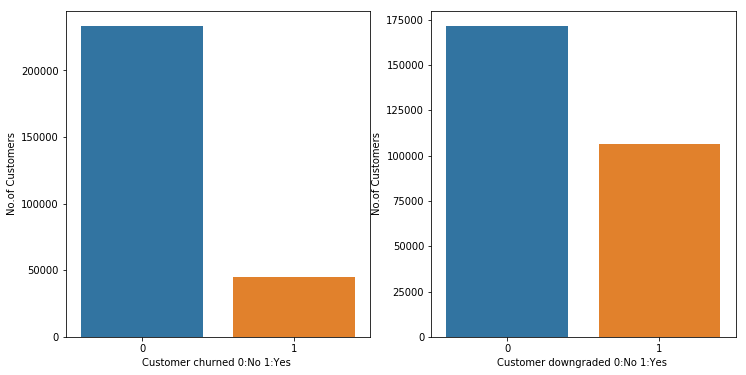

In [20]:
# Plot churn and downgrade count
plt.figure(figsize=(12,6))

# Churn
plt.subplot(1, 2, 1)
count_churn = df_sprk.select(['churn']).toPandas()
sns.countplot(count_churn['churn']);
plt.xlabel('Customer churned 0:No 1:Yes ')
plt.ylabel('No.of Customers')

# Downgrades
plt.subplot(1, 2, 2)
count_downgrade = df_sprk.select(['Downgraded']).toPandas()
sns.countplot(count_downgrade['Downgraded']);
plt.xlabel('Customer downgraded 0:No 1:Yes ')
plt.ylabel('No.of Customers')

In [21]:
count_churn.shape

(278154, 1)

In [22]:
print(count_churn['churn'].value_counts())
print(count_downgrade['Downgraded'].value_counts())

0    233290
1     44864
Name: churn, dtype: int64
0    171502
1    106652
Name: Downgraded, dtype: int64


#### Out of 278 thousand users around 44.9 thousand customers were identified as churn and 106.7 thousand customers were identifies as downgraded

In [23]:
# Function
def plot_charts(fieldkpi,field_group):
    """
    Input:
      1 - fieldkpi- Which kpi to be aggregated and displayed
      2 - field_group - Onwhich fields the kpis are to be aggregared
    
    Output:
      Charts
    """
    #defining data to be plotted
    df_sprk_plot = df_sprk.dropDuplicates(['userId', field_group]).groupby([fieldkpi,field_group]).count().sort(fieldkpi).toPandas()
    #Adding Yes/No for 1 and 0 in Churn
    Value_map = {1:'yes', 0:'no'}
    df_sprk_plot[fieldkpi] = df_sprk_plot[fieldkpi].map(Value_map)
    #Plotting
    sns.barplot(x=fieldkpi, y='count', hue=field_group, data=df_sprk_plot);

Text(0,0.5,'No.of Customers')

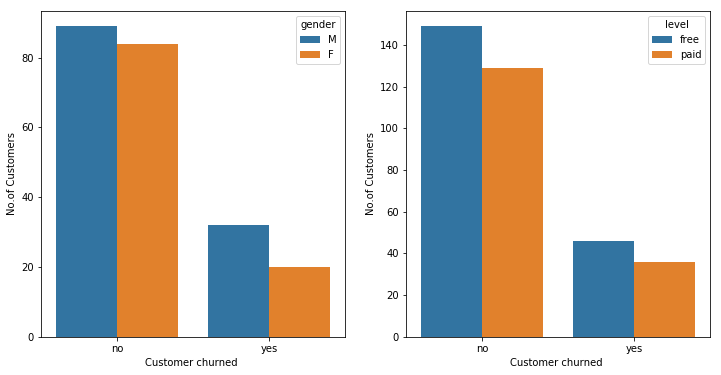

In [24]:
#Churn by gender and level
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plot_charts('churn','gender')
plt.xlabel('Customer churned ')
plt.ylabel('No.of Customers')

plt.subplot(1, 2, 2)
plot_charts('churn','level')
plt.xlabel('Customer churned ')
plt.ylabel('No.of Customers')

#### Total number of males customers are greater than females and there number is also greater for Churned users. Also, Chruned proportion is higher in males than females.

#### Similarly, total number of free customers are greater than paid and there number is also greater for Churned users. Also, paid cutomers are less likely to churn.


Text(0,0.5,'No.of Customers')

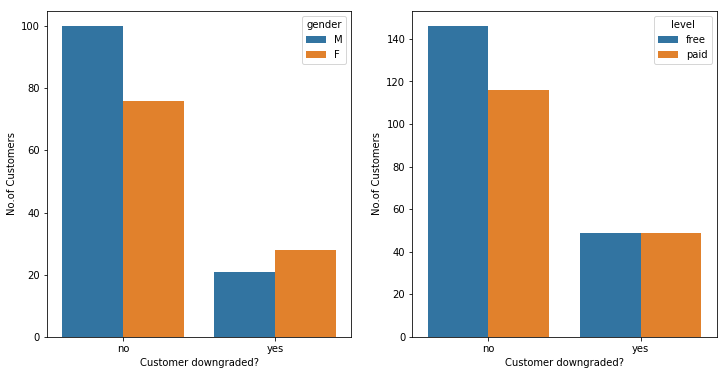

In [25]:
#Downgrade by gender and level
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plot_charts('Downgraded','gender')
plt.xlabel('Customer downgraded')
plt.ylabel('No.of Customers')

plt.subplot(1, 2, 2)
plot_charts('Downgraded','level')
plt.xlabel('Customer downgraded')
plt.ylabel('No.of Customers')

#### Proportion of male users downgraded is lower than females.

#### Proportion of free users downgraded is lower than paid.

Text(0.5,0,'Average songs played per session')

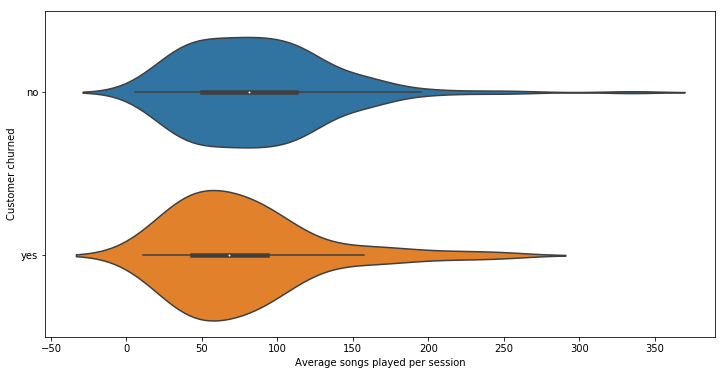

In [26]:
# Distribution of no.of songs played in each session in each session for churn and non churn
plt.figure(figsize=(12,6))
plot_dist = df_sprk.groupby('churn', 'userId', 'sessionId').count() \
                   .groupby('churn', 'userId').agg({'count':'avg'}) \
                   .withColumnRenamed('avg(count)', 'Avgsongs_played').toPandas()

Value_map = {1:'yes', 0:'no'}
plot_dist['churn'] = plot_dist['churn'].map(Value_map)

sns.violinplot(x='Avgsongs_played', y='churn',orient='h',data=plot_dist)
plt.ylabel('Customer churned')
plt.xlabel('Average songs played per session')

### Average songs played per session is lesser for Churned users 

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Based on our observation and exploratory data analyis, we have identified following key features that will be used for modelling:

    User id 
    Gender
    Level 
    Churn
    Downgrade
    Number of sessions on the portal
    No.of Songs each user has listened to
    No.of Artists each user has listened to
    Average time spent on the portal



In [27]:
# Unique users and churn flag
userid_churn = df_sprk.dropDuplicates(['userId']).sort('userId').select(['userId','churn'])
userid_churn.show(5)

+------+-----+
|userId|churn|
+------+-----+
|    10|    0|
|   100|    0|
|100001|    1|
|100002|    0|
|100003|    1|
+------+-----+
only showing top 5 rows



In [28]:
# Gender
gender = df_sprk.select("userId", "gender").dropDuplicates()
# Changing to 0 and 1 instead of char for modeling purpose
gender = gender.replace(["M", "F"], ["0", "1"], "gender")
gender = gender.select("userId", gender.gender.cast("int"))
gender.show(5)

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
+------+------+
only showing top 5 rows



In [29]:
# Level
level = df_sprk.select("userId", "level").dropDuplicates()
# Changing to 0 and 1 instead of char for modeling purpose
level = level.replace(["free", "paid"], ["0", "1"], "level")
level = level.select("userId", level.level.cast("int"))
level.show(5)

+------+-----+
|userId|level|
+------+-----+
|100021|    0|
|200021|    0|
|200001|    0|
|     6|    0|
|300022|    1|
+------+-----+
only showing top 5 rows



In [30]:
#users downgrade
downgrade = df_sprk.select("userId", "Downgraded").dropDuplicates()
downgrade = downgrade.select("userId", downgrade.Downgraded.cast("int"))
downgrade.show(5)

+------+----------+
|userId|Downgraded|
+------+----------+
|100010|         0|
|200002|         0|
|   125|         0|
|   124|         0|
|    51|         0|
+------+----------+
only showing top 5 rows



In [31]:
# No.of sessions 
session_count = df_sprk.select("userId", "sessionId").dropDuplicates().groupby("userId").count()
session_count = session_count.withColumnRenamed("count", "session_count")
session_count.show(5)

+------+-------------+
|userId|session_count|
+------+-------------+
|100010|            7|
|200002|            6|
|   125|            1|
|    51|           10|
|   124|           29|
+------+-------------+
only showing top 5 rows



In [32]:
# No.of Songs each user has listened to
songs = df_sprk.where(df_sprk.song!='null').groupby('userId') \
    .agg({'song':'count'}).orderBy('userId') \
    .withColumnRenamed("count(song)", "song_count")
songs.show(5)

+------+----------+
|userId|song_count|
+------+----------+
|    10|       673|
|   100|      2682|
|100001|       133|
|100002|       195|
|100003|        51|
+------+----------+
only showing top 5 rows



In [33]:
# No.of Artists each user has listened to
artists = df_sprk.dropDuplicates(['userId','artist']).groupby('userId') \
    .agg({'artist':'count'}).orderBy('userId') \
    .withColumnRenamed("count(artist)", "artist_count")
artists.show(5)

+------+------------+
|userId|artist_count|
+------+------------+
|    10|         565|
|   100|        1705|
|100001|         125|
|100002|         184|
|100003|          50|
+------+------------+
only showing top 5 rows



In [34]:
# Average time spent on the portal
user_time = df_sprk.groupby('userId', 'sessionId').agg(((max(df_sprk.ts)-min(df_sprk.ts))/(1000*60)).alias("sessiontime"))
user_time = user_time.groupby("userId").agg({'sessiontime':'avg'}).orderBy('userId')\
                     .withColumnRenamed('avg(sessiontime)', 'avg_sessiontime')
user_time.show(5)

+------+------------------+
|userId|   avg_sessiontime|
+------+------------------+
|    10|459.74722222222226|
|   100| 316.5190476190476|
|100001|148.15833333333333|
|100002|201.18333333333334|
|100003| 99.11666666666667|
+------+------------------+
only showing top 5 rows



In [35]:
# Combining all features and preparing master table
masterdata_features = userid_churn 
features = [gender,level,downgrade,session_count,songs,artists,user_time]

for feature in features:
    masterdata_features = masterdata_features.join(feature,'userId')

masterdata_features.show(5)

+------+-----+------+-----+----------+-------------+----------+------------+-----------------+
|userId|churn|gender|level|Downgraded|session_count|song_count|artist_count|  avg_sessiontime|
+------+-----+------+-----+----------+-------------+----------+------------+-----------------+
|    44|    0|     1|    0|         0|            3|       429|         371|586.3388888888888|
|    44|    0|     1|    1|         0|            3|       429|         371|586.3388888888888|
|    46|    0|     1|    1|         0|           10|       918|         710|378.0466666666666|
|    46|    0|     1|    0|         0|           10|       918|         710|378.0466666666666|
|    41|    0|     1|    1|         0|           12|      1894|        1319|657.6722222222223|
+------+-----+------+-----+----------+-------------+----------+------------+-----------------+
only showing top 5 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [37]:
# Split data to train and test sets
train, test = masterdata_features.randomSplit([0.8, 0.2], seed=42)

In [38]:
# Define vector assembler, standard scaler and indexing
assembler = VectorAssembler(inputCols=masterdata_features.columns[2:],outputCol='featureVector')
scaler = StandardScaler(inputCol="featureVector", outputCol="features", withStd=True)
indexer = StringIndexer(inputCol="churn", outputCol="label")

In [39]:
#Evaluator for f1 score
evaluator = MulticlassClassificationEvaluator(metricName='f1')

#### SVM Model

In [40]:
svm = LinearSVC(labelCol="label", featuresCol="features",maxIter=10)
# Creating Pipeline
pipeline = Pipeline(stages=[assembler, scaler, indexer, svm])
# Grid Parameters
param = ParamGridBuilder().build()
#Validation
svm_crossval = CrossValidator(estimator=pipeline, estimatorParamMaps=param, evaluator=evaluator, numFolds=3)

### Logistic Regression Model

In [41]:
logit_reg =  LogisticRegression(labelCol="label", featuresCol="features", maxIter=8, regParam=0.0, elasticNetParam=0)
# Creating Pipeline
pipeline = Pipeline(stages=[assembler, scaler, indexer, logit_reg])
# Grid Parameters
param = ParamGridBuilder().addGrid(logit_reg.regParam,[0.0, 0.001, 0.01, 0.1]).build()
#Validation
logit_crossval = CrossValidator(estimator=pipeline, estimatorParamMaps=param, evaluator=evaluator, numFolds=3)

### Random Forest Model

In [45]:
rand_for = RandomForestClassifier(numTrees=18, maxDepth=3, labelCol="label", seed=42)
# Creating Pipeline
pipeline = Pipeline(stages=[assembler, scaler, indexer, rand_for])
# Grid Parameters
param = ParamGridBuilder().addGrid(rand_for.numTrees,[18, 50]).addGrid(rand_for.maxDepth,[2,3, 5]).build()
#Validation
rf_crossval = CrossValidator(estimator=pipeline, estimatorParamMaps=param, 
                             evaluator=evaluator, numFolds=3)

In [46]:
def model_eval(model,modelname):
    """
    Input:
      1 - Model- Which model to evaluate
      2 - Modelname - Name of the pipeline model created
    
    Output:
      Fitted Model
    """
    #Model training
    model_evl = model.fit(train)
    # Model evaluation
    print(modelname)
    print("\nTraining Metrics: ",model_evl.avgMetrics)
    # Prediction and test performance
    predictions = model_evl.transform(test)
    print("\nTest Metric 'F1-Score': ",MulticlassClassificationEvaluator().setMetricName("f1").evaluate(predictions))
    return model_evl

In [44]:
#Evaluate SVM
eval_svm = model_eval(svm_crossval, "SVM Classifier")

SVM Classifier

Training Metrics:  [0.6593343531154163]

Test Metric 'F1-Score':  0.7224989622249897


In [47]:
eval_lr = model_eval(logit_crossval, "Logistic Regression")

Logistic Regression

Training Metrics:  [0.6544635482446115, 0.6544635482446115, 0.6561048941482525, 0.6593343531154163]

Test Metric 'F1-Score':  0.7224989622249897


In [48]:
#Evaluate Random Forest
eval_rf = model_eval(rf_crossval, "Random Forest Classifier")

Random Forest Classifier

Training Metrics:  [0.6593343531154163, 0.6654968133356551, 0.7013971209176768, 0.6593343531154163, 0.6593343531154163, 0.690288232377783]

Test Metric 'F1-Score':  0.7368026535239774


### Training score for all three models is around ~66% but Random Forest model has highest accuracy/ F1-score ~74% of three models

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.